In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/google-map-nyc-40474541735-kor-version/google_map_NYC_(40.4-74.541-73.5)_KOR_VERSION.png
/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv


##### Reference
* https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration
* http://egloos.zum.com/incredible/v/7479081

In [2]:
pip install haversine

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
from PIL import Image

from haversine import haversine

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

%matplotlib inline

In [4]:
train_df = pd.read_csv("/kaggle/input/new-york-city-taxi-fare-prediction/train.csv", nrows= 1000000, parse_dates=["pickup_datetime"])
test_df = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/test.csv', parse_dates=["pickup_datetime"])
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
train_df.shape

(1000000, 8)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype              
---  ------             --------------    -----              
 0   key                1000000 non-null  object             
 1   fare_amount        1000000 non-null  float64            
 2   pickup_datetime    1000000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   1000000 non-null  float64            
 4   pickup_latitude    1000000 non-null  float64            
 5   dropoff_longitude  999990 non-null   float64            
 6   dropoff_latitude   999990 non-null   float64            
 7   passenger_count    1000000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 61.0+ MB


In [7]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000
mean,11.348079,-72.526640,39.929008,-72.527860,39.919954,1.684924
std,9.822090,12.057937,7.626154,11.324494,8.201418,1.323911
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


# EDA (Before preprocessing)
* Plot Null Values
* Get "Total Distance" Colums (Useing haversine libaray) and Plot it
* Get "Pick up Year" and Plot it
* Plot Columns Histogram
* Plot Columns Boxplot
* Plot Columns kdeplot


In [8]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


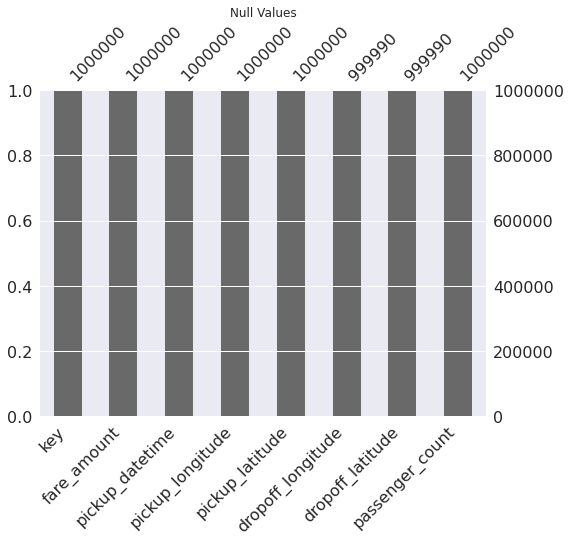

In [9]:
f, ax = plt.subplots(1,1, figsize=(8,6))
msno.bar(train_df, ax=ax)
plt.title('Null Values')
plt.show()

In [10]:
pd.DataFrame(train_df.isnull().sum(), columns=["Train Null Count"])

,Train Null Count
key,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,10
dropoff_latitude,10
passenger_count,0


In [11]:
pd.DataFrame(test_df.isnull().sum(), columns=["Test Null Count"])

,Test Null Count
key,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


In [12]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [13]:
def get_total_distance(df):
    a1 = df['pickup_latitude']
    a2 = df['dropoff_latitude']
    
    b1 = df['pickup_longitude']
    b2 = df['dropoff_longitude']

    pick_up = (a1, b1) 
    drop_off = (a2, b2)
    return haversine(pick_up, drop_off)
    # haversine function : Get Distance to use x(latitude, longitude), y(latitude, longitude)

-> When you need Total Distance, Then you can use this function

In [14]:
train_df['total_distance'] = train_df.apply(lambda x: get_total_distance(x),axis=1)
test_df['total_distance'] = test_df.apply(lambda x: get_total_distance(x),axis=1)
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,total_distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.030765
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.450145
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389527
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.799274
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999160


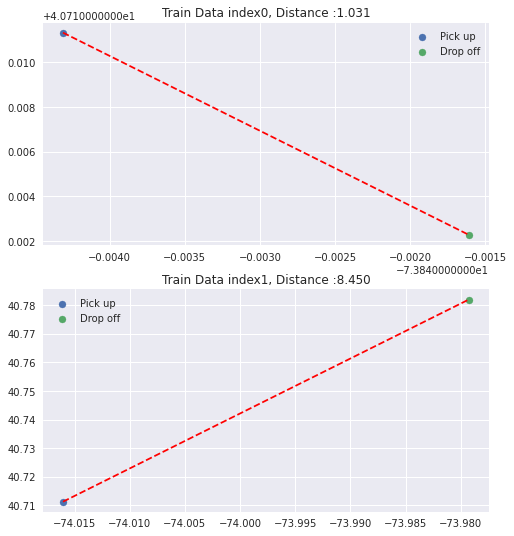

In [15]:
fig = plt.figure(figsize=(8,9))

for i in range(2):
    plt.subplot(2, 1, i+1)
    plt.title("Train Data index{}, Distance :{:.3f}".format(i, train_df['total_distance'][i]))
    plt.scatter(train_df['pickup_longitude'][i], train_df['pickup_latitude'][i], label="Pick up")
    plt.scatter(train_df['dropoff_longitude'][i], train_df['dropoff_latitude'][i], label="Drop off")
    plt.plot([train_df['pickup_longitude'][i],train_df['dropoff_longitude'][i]],[train_df['pickup_latitude'][i],train_df['dropoff_latitude'][i]],'r--')
    plt.legend()
    
plt.show()

In [16]:
f = px.scatter_3d(train_df[:10000], x='pickup_latitude', y='pickup_longitude', z='total_distance',
                    color='fare_amount')
f.show()

* (pickup_longitude, dropoff_longitude) per fare_amount)

In [17]:
f = px.scatter_3d(train_df[:10000], x='dropoff_latitude', y='dropoff_longitude', z='total_distance',
                    color='fare_amount')
f.show()

In [18]:
train_df['pickup_datetime_year'] = train_df['pickup_datetime'].dt.year
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,total_distance,pickup_datetime_year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.030765,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.450145,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389527,2011
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.799274,2012
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999160,2010


In [19]:
train_df['pickup_datetime_year'].value_counts()

2012    161165
2011    158892
2013    156167
2009    154029
2010    150850
2014    149073
2015     69824
Name: pickup_datetime_year, dtype: int64

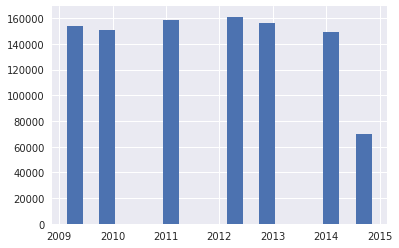

In [20]:
plt.hist(train_df['pickup_datetime_year'], rwidth=0.5)
plt.show()

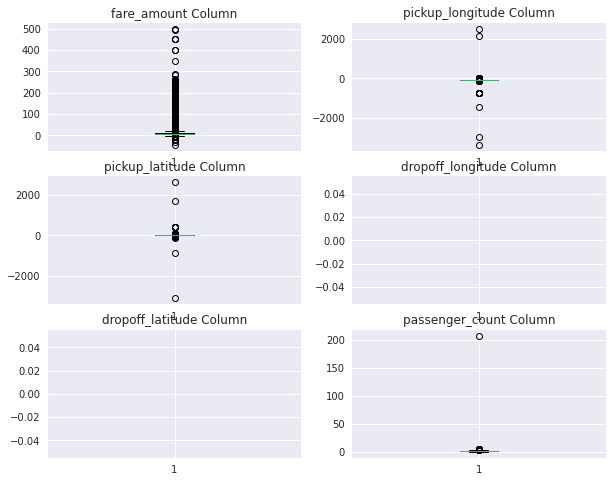

In [21]:
df_index =[1,3,4,5,6,7]
fig = plt.figure(figsize=(10,8))

for num, i in enumerate(df_index):
    plt.subplot(3,2,num+1)
    plt.title("{} Column".format(train_df.columns[i]))
    plt.boxplot(train_df.iloc[:,i])

plt.show()

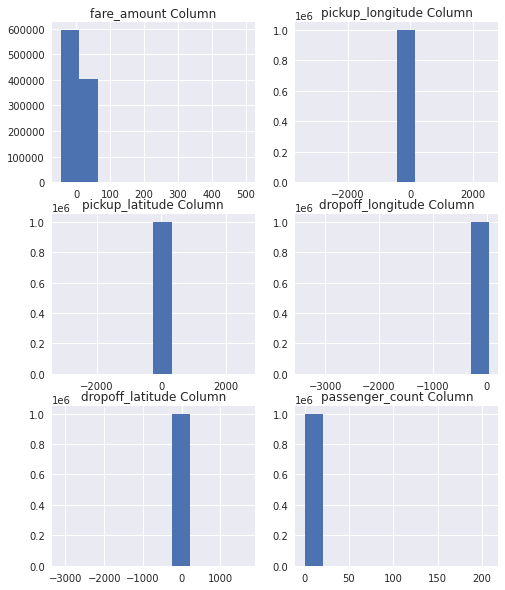

In [22]:
df_index =[1,3,4,5,6,7]
fig = plt.figure(figsize=(8,10))

for num, i in enumerate(df_index):
    plt.subplot(3,2,num+1)
    plt.title("{} Column".format(train_df.columns[i]))
    plt.hist(train_df.iloc[:,i])

plt.show()

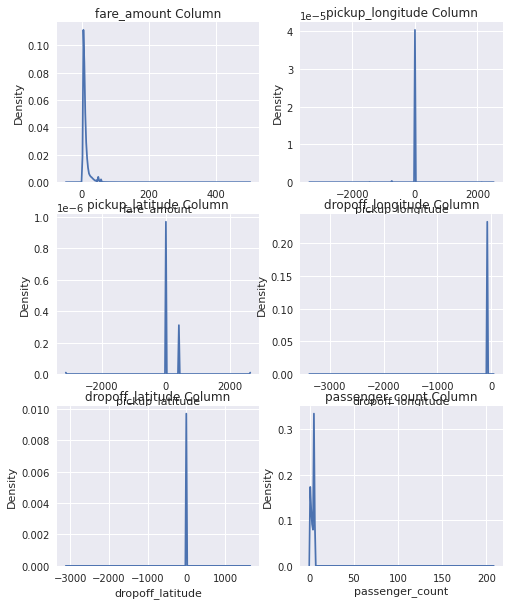

In [23]:
df_index =[1,3,4,5,6,7]
fig = plt.figure(figsize=(8,10))

for num, i in enumerate(df_index):
    plt.subplot(3,2,num+1)
    plt.title("{} Column".format(train_df.columns[i]))
    sns.kdeplot(train_df.iloc[:,i])

plt.show()

# Preprocessing
* Processing Outlier Values
* Processing Old Data

##### New York <br/>
* latitude  	40°29'40"N - 45°0'42"N (~40.6643)
* longitude 	71°47'25"W - 79°45'54"W (~-73.9385)
* This kernel will use (40.489707, -74.262378) => (40.937760, -73.698009)

In [24]:
def data_cleansing(df, data="Train"):
    
    print("Before cleansing shape : {}".format(df.shape))
    print("----- CLEANSING -----")
    
    if data=="Train":
        df = df.drop(df[df['fare_amount'] <= 2].index)
        df = df.drop(df[df['fare_amount'] >= 100].index)
        print(df.shape)
    
    df = df.drop(df[df['pickup_longitude'] <= -74.5].index)
    df = df.drop(df[df['pickup_longitude'] >= -73.5].index)
    print(df.shape)
   
    df = df.drop(df[df['pickup_latitude'] <= 40.4].index)
    df = df.drop(df[df['pickup_latitude'] >= 41].index)
    print(df.shape)
   
    df = df.drop(df[df['dropoff_longitude'] <= -74.5].index)
    df = df.drop(df[df['dropoff_longitude'] >= -73.5].index)
    print(df.shape)
   
    df = df.drop(df[df['dropoff_latitude'] <= 40.4].index)
    df = df.drop(df[df['dropoff_latitude'] >= 41].index)
    print(df.shape)
       
    df = df.drop(df[df['passenger_count'] <= 0].index)
    df = df.drop(df[df['passenger_count'] >= 7].index)
    
    print("----- CLEANSING -----")
    print("After cleansing shape : {}".format(df.shape))
    
    return df

In [25]:
train_df['fare_amount'].sort_values(ascending=False)

101885    500.00
247671    495.00
233874    450.00
329010    450.00
287638    450.00
           ...  
298412     -6.50
427602    -18.10
512494    -20.00
534751    -29.87
58937     -44.90
Name: fare_amount, Length: 1000000, dtype: float64

In [26]:
train_df = data_cleansing(train_df, "Train")

Before cleansing shape : (1000000, 10)
----- CLEANSING -----
(999488, 10)
(979526, 10)
(979293, 10)
(978311, 10)
(978196, 10)
----- CLEANSING -----
After cleansing shape : (974706, 10)


# EDA (After Preporcessing)

In [27]:
f = px.scatter_3d(train_df[:10000], x='pickup_latitude', y='pickup_longitude', z='total_distance',
                    color='fare_amount')
f.show()

In [28]:
f = px.scatter_3d(train_df[:10000], x='dropoff_latitude', y='dropoff_longitude', z='total_distance',
                    color='fare_amount')
f.show()

In [29]:
map_img = plt.imread('../input/google-map-nyc-40474541735-kor-version/google_map_NYC_(40.4-74.541-73.5)_KOR_VERSION.png')

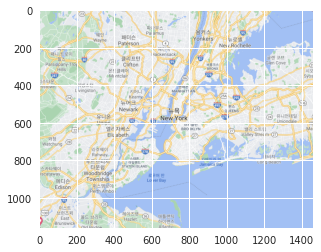

In [30]:
plt.imshow(map_img)
plt.show()

##### You can use this img
* Add data => Search the "google_mapNYC(40.4-74.541-73.5)_KOR_VERSION.png"

In [31]:
def plot_map(df, map_img, s=10, alpha=0.2):
    f, ax = plt.subplots(1, 2, figsize=(16,8))
    ax[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    ax[0].set_xlim(-74.5, -73.5)
    ax[0].set_ylim((40.4, 41))
    ax[0].set_title('Pickup locations')
    ax[0].imshow(map_img, zorder=0, extent=(-74.5, -73.5, 40.4, 41))

    ax[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    ax[1].set_xlim(-74.5, -73.5)
    ax[1].set_ylim((40.4, 41))
    ax[1].set_title('Dropoff locations')
    ax[1].imshow(map_img, zorder=0, extent=(-74.5, -73.5, 40.4, 41))

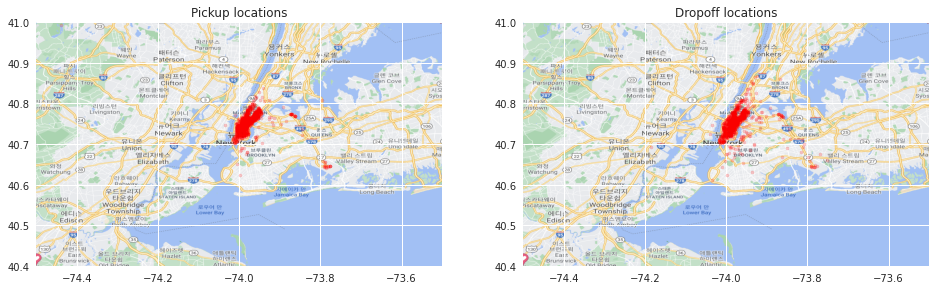

In [32]:
plot_map(train_df[:1000], map_img)

# Feature Engineering
* Get DateTime Type Column
* Prepocessing

In [33]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,total_distance,pickup_datetime_year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.030765,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.450145,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389527,2011
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.799274,2012
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999160,2010


In [34]:
train_df["year"] = train_df["pickup_datetime"].dt.year
train_df["weekday"] = train_df["pickup_datetime"].dt.weekday
train_df["hour"] = train_df["pickup_datetime"].dt.hour

test_df["year"] = test_df["pickup_datetime"].dt.year
test_df["weekday"] = test_df["pickup_datetime"].dt.weekday
test_df["hour"] = test_df["pickup_datetime"].dt.hour

In [35]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,total_distance,pickup_datetime_year,year,weekday,hour
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.030765,2009,2009,0,17
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.450145,2010,2010,1,16
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389527,2011,2011,3,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.799274,2012,2012,5,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999160,2010,2010,1,7


In [36]:
test_df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,total_distance,year,weekday,hour
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2.323263,2015,1,13
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2.425356,2015,1,13
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,0.618629,2011,5,11
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,1.961035,2012,5,21
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,5.387309,2012,5,21


In [37]:
train_df.drop(['key','pickup_datetime','pickup_datetime_year'], axis=1, inplace=True)
test_df.drop(['key','pickup_datetime'], axis=1, inplace=True)
train_df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,total_distance,year,weekday,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,1.030765,2009,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,8.450145,2010,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,1.389527,2011,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2.799274,2012,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,1.999160,2010,1,7


In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974706 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        974706 non-null  float64
 1   pickup_longitude   974706 non-null  float64
 2   pickup_latitude    974706 non-null  float64
 3   dropoff_longitude  974706 non-null  float64
 4   dropoff_latitude   974706 non-null  float64
 5   passenger_count    974706 non-null  int64  
 6   total_distance     974706 non-null  float64
 7   year               974706 non-null  int64  
 8   weekday            974706 non-null  int64  
 9   hour               974706 non-null  int64  
dtypes: float64(6), int64(4)
memory usage: 114.1 MB


# Modeling
* Not yet

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

In [40]:
x = train_df.drop('fare_amount', axis=1)
y = train_df['fare_amount']

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print("X train data shape : {}".format(x_train.shape))
print("Y train data shape : {}".format(y_train.shape))

print("X test data shape : {}".format(x_test.shape))
print("Y test data shape : {}".format(y_test.shape))

X train data shape : (682294, 9)
Y train data shape : (682294,)
X test data shape : (292412, 9)
Y test data shape : (292412,)


In [42]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.6)
print("X validation data shape : {}".format(x_val.shape))
print("Y validation data shape : {}".format(y_val.shape))

print("X test data shape : {}".format(x_test.shape))
print("Y test data shape : {}".format(y_test.shape))

X validation data shape : (175448, 9)
Y validation data shape : (175448,)
X test data shape : (116964, 9)
Y test data shape : (116964,)


#### - Lgbm Regressor

In [43]:
train_data = lgb.Dataset(x_train, label=y_train)
val_data = lgb.Dataset(x_val, label=y_val)

In [44]:
params = {
    'n_estimators': 5000,
    'num_leaves': 500,
    'max_depth': -1,
    'min_data_in_leaf': 1000,
    'learning_rate': 0.003,
    'boosting': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'Is_training_metric': True,
    'n_jobs': -1
}

In [45]:
model = lgb.train(params,
                  train_data,
                  valid_sets=val_data, 
                  valid_names=['train','valid'],
                  early_stopping_rounds=100)

[LightGBM] [Warning] Unknown parameter: Is_training_metric
[LightGBM] [Warning] Unknown parameter: Is_training_metric
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1321
[LightGBM] [Info] Number of data points in the train set: 682294, number of used features: 9
[LightGBM] [Warning] Unknown parameter: Is_training_metric
[LightGBM] [Info] Start training from score 11.287515
[1]	train's l2: 88.265
Training until validation scores don't improve for 100 rounds
[2]	train's l2: 87.8295
[3]	train's l2: 87.3967
[4]	train's l2: 86.9664
[5]	train's l2: 86.5386
[6]	train's l2: 86.1135
[7]	train's l2: 85.6907
[8]	train's l2: 85.2703
[9]	train's l2: 84.8528
[10]	train's l2: 84.4359
[11]	train's l2: 84.0217
[12]	train's l2: 83.6099
[13]	train's l2: 83.2021
[14]	train's l2: 82.795
[15]	train's

In [46]:
print('Starting predicting...')
# predict
y_pred = model.predict(x_test)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred))

Starting predicting...
The rmse of prediction is: 11.834668706765559


# Submission

In [47]:
submission = pd.read_csv('../input/new-york-city-taxi-fare-prediction/sample_submission.csv')
submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35


In [48]:
submission.shape

(9914, 2)

In [49]:
pred = model.predict(test_df)

In [50]:
print(pred[:10])

[10.16069975 11.77434466  4.36081581  7.40332118 13.55386338  8.27041004
  5.24988607 48.54179833 10.59220663  6.80065227]


In [51]:
submission['fare_amount'] = pred

In [52]:
submission.to_csv("submission.csv", index=False)